# XRF 2D forward model: 5 elements, 5 x 5 sample

In [1]:
import os
import numpy as np
import dxchange

import torch as tc
# tc.set_default_tensor_type(tc.DoubleTensor)
tc.set_default_tensor_type(tc.FloatTensor)
tc.pi = tc.acos(tc.zeros(1)).item() * 2
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import rotate as sp_rotate

from tqdm import tqdm
from scipy.ndimage import rotate as sp_rotate
import xraylib as xlib
import xraylib_np as xlib_np
import time

In [2]:
print(tc.cuda.device_count())

2


In [3]:
if tc.cuda.is_available():  
    dev = "cuda:1" 
    print("running on GPU")
else:  
    dev = "cpu"
    print("running on CPU")

device = tc.device(dev)
print("device = %s" %device)

running on GPU
device = cuda:1


In [4]:
# device = tc.device(dev)  
# a = tc.zeros(4,3)    
# a = a.to(device)
# print(a.device)

In [5]:
# device = tc.device("cpu")

In [6]:
# dev = "cpu"

# Load data:

In [7]:
data = np.load('./data/sample3_data/XRF_sample3.npy').astype(np.float32)
# data = np.load('./data/sample3_data/XRF_sample3.npy')
print(data.shape)

data = tc.from_numpy(np.transpose(data, axes=(0,2,1)))
print(data.shape)

(5, 5, 8)
torch.Size([5, 8, 5])


tensor([[     0.0000,      0.0000, 168212.5781,      0.0000,      0.0000],
        [     0.0000,   2347.1602, 107163.7969,  81912.1172,      0.0000],
        [     0.0000,      0.0000,  80186.4062,  95002.6641,      0.0000],
        [     0.0000,   2347.1602, 107983.3750,  82409.2656,      0.0000],
        [     0.0000,      0.0000, 171843.6250,      0.0000,      0.0000]])


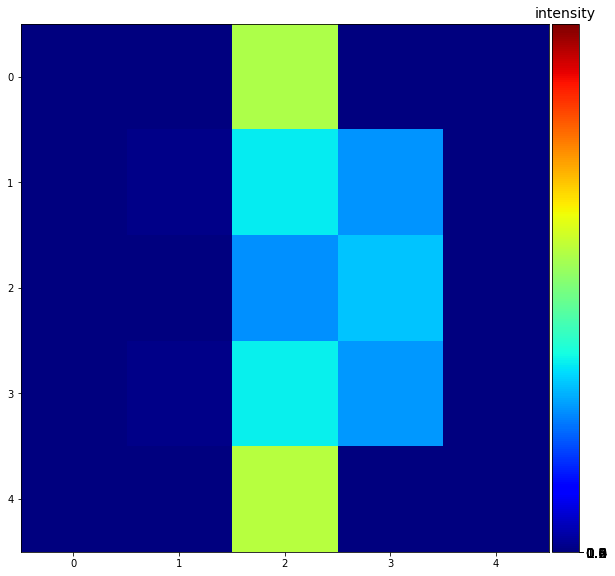

In [8]:
fig6 = plt.figure(figsize=(10,10))
gs6 = gridspec.GridSpec(nrows=1, ncols=1)

fig6_ax1 = fig6.add_subplot(gs6[0,0])
fig6_ax1.set_xticks(np.arange(0, 5, 1))
fig6_ax1.set_yticks(np.arange(0, 12, 1))
# fig6_ax1.grid(color='w', linewidth=2)
# fig6_ax1.set_xticks(np.arange(0, image_size, 1))
# fig6_ax1.set_yticks(np.arange(0, image_size, 1))
pos = fig6_ax1.imshow(data[:,6,:], cmap='jet', vmin=0, vmax=300000, origin='upper')
divider = make_axes_locatable(fig6_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')



# plt.imshow(data[:,0,:])
# plt.xlabel('position')
# plt.ylabel('angle')
# plt.show()
print(data[:,6,:])

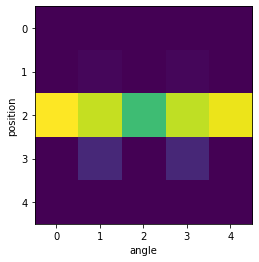

In [9]:
plt.imshow(tc.transpose(data[:,4,:], 0,1)) # Third angle:
plt.xlabel('angle')
plt.ylabel('position')
plt.show()

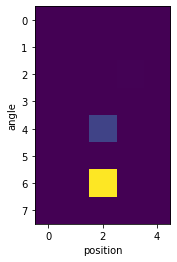

tensor([[0.0000e+00, 1.5655e-19, 2.2200e-01, 3.9396e-01, 1.1639e-01],
        [0.0000e+00, 3.6949e-14, 3.6198e+01, 6.4305e+01, 1.8977e+01],
        [4.8991e-06, 1.1937e+00, 3.3891e+02, 5.9268e+02, 1.3094e+02],
        [0.0000e+00, 0.0000e+00, 2.3113e-02, 4.1008e-02, 1.2117e-02],
        [0.0000e+00, 5.8218e+02, 3.1016e+04, 3.9013e+03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0718e-13, 4.4087e-08, 0.0000e+00],
        [0.0000e+00, 2.3472e+03, 1.0716e+05, 8.1912e+04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 7.3066e-07, 1.1951e+03, 0.0000e+00]])


In [57]:
plt.imshow(data[0,:,:]) # [angle, position, line_idx]
plt.xlabel('position')
plt.ylabel('angle')
plt.show()
print(data[1,:,:])

# Test how reshape works:

In [11]:
# xraylib uses keV
fl_K = np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
                 xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE])

fl_L = np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
                 xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
                 xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE])

fl_M = np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])

fl_K_str = ["Ka1", "Ka2", "Ka3", "Kb1", "Kb2", "Kb3", "Kb4", "Kb5"]
fl_L_str = ["La1", "La2", "Lb1", "Lb2", "Lb3", "Lb4","Lb5", "Lb6",
             "Lb7", "Lb9", "Lb10", "Lb15", "Lb17"]
fl_Ma_str = ["Ma1", "Ma2", "Mb"]

fl_line_groups = np.array(["K", "L", "M"])

In [12]:
def MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True):
    """   
    Parameters
    ----------
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}

    probe_energy : ndarray
        This array is an array with only 1 element. The element is the keV energy of the incident beam.

    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels

    sample_size_cm: scalar
        sample size in cm

    fl_line_groups : ndarray, optional
        DESCRIPTION. The default is np.array(["K", "L", "M"]).

    fl_K : ndarray, optional
        The default is fl_K, an array of sub-lines of K line with the required format by xraylib.

    fl_L : ndarray, optional
        The default is fl_L, an array of sub-lines of L line with the required format by xraylib.

    fl_M : ndarray, optional
        The default is fl_M, an array of sub-lines of M line with the required format by xraylib.

    group_lines : boolean, optional
        Whether treating all K (or L, M) sub-lines as a single line. The default is True.

    Returns
    -------
    FL_all_elements_dic : dictionary
        The dictionary has 3 items. 
        1st item 
        key: "(element_name, Line)"
        value: an ndarray of ndarrays of 2 elements(type: string), [element symbol, line group]
        e.g. [['C', 'K'], ['O', 'K'], ['Si', 'K'], ['Si', 'L']]

        2nd item
        key: "fl_energy"
        value: float, Fluorescence energy in keV for each line of all element

        3rd item: "detected_fl_unit_concentration"
        key: fluorescence yield assuming a unit concentration [1 g/cm^3 ]
    """

    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))

    n_line_group = len(fl_line_groups)
    FL_all_elements_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    voxel_size = sample_size_cm/sample_size_n   

    fl_cs_K = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_K, probe_energy)
    fl_cs_L = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_L, probe_energy)
    fl_cs_M = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_M, probe_energy)

    # Remove the extra dimension with only 1 element
    fl_cs_K = np.reshape(fl_cs_K, (fl_cs_K.shape[:-1]))
    fl_cs_L = np.reshape(fl_cs_L, (fl_cs_L.shape[:-1]))
    fl_cs_M = np.reshape(fl_cs_M, (fl_cs_M.shape[:-1]))

    fl_energy_K = xlib_np.LineEnergy(aN_ls, fl_K)
    fl_energy_L = xlib_np.LineEnergy(aN_ls, fl_L)
    fl_energy_M = xlib_np.LineEnergy(aN_ls, fl_M)

    FL_all_elements_dic = {"(element_name, Line)": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([]),
                           "n_line_group_each_element": np.array([]), "n_lines": None}
    if group_lines == True:
        fl_energy_group = np.zeros((len(element_ls),n_line_group))
        fl_cs_group = np.zeros((len(element_ls),n_line_group))
        for i, element_name in enumerate(element_ls): 

            if np.sum(fl_energy_K[i] != 0):
                fl_energy_group[i,0] = np.average(fl_energy_K[i], weights=fl_cs_K[i]) 
                fl_cs_group[i,0] = np.sum(fl_cs_K[i])
            else:
                fl_energy_group[i,0] = 0
                fl_cs_group[i,0] = 0

            if np.sum(fl_energy_L[i] != 0):
                fl_energy_group[i,1] = np.average(fl_energy_L[i], weights=fl_cs_L[i]) 
                fl_cs_group[i,1] = np.sum(fl_cs_L[i])
            else:
                fl_energy_group[i,1] = 0
                fl_cs_group[i,1] = 0

            if np.sum(fl_energy_M[i] != 0):
                fl_energy_group[i,2] = np.average(fl_energy_M[i], weights=fl_cs_M[i]) 
                fl_cs_group[i,2] = np.sum(fl_cs_M[i])
            else:
                fl_energy_group[i,2] = 0
                fl_cs_group[i,2] = 0

            element_Line = fl_line_groups[fl_energy_group[i]!= 0]
            element_Line = [[element_name, element_Line[j]] for j in range(len(element_Line))]
            for k in range(len(element_Line)):
                FL_all_elements_dic["(element_name, Line)"].append(element_Line[k])     

            Line_energy = fl_energy_group[i][fl_energy_group[i]!=0]
            FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], Line_energy)
            fl_unit_con = fl_cs_group[i][fl_energy_group[i]!=0] * voxel_size
            FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_unit_con)
            FL_all_elements_dic["n_line_group_each_element"] = np.append(FL_all_elements_dic["n_line_group_each_element"], len(fl_unit_con))
            
        FL_all_elements_dic["(element_name, Line)"] = np.array(FL_all_elements_dic["(element_name, Line)"])
    
    FL_all_elements_dic["n_lines"] = len(FL_all_elements_dic["(element_name, Line)"])
    return FL_all_elements_dic

In [13]:
theta_st = 0
theta_end = np.pi
n_theta = 5
theta_ls = - tc.linspace(theta_st, theta_end, n_theta)
this_theta_idx = 0
sample_size_n = 5
sample_height_n = 1
sample_size_cm = 0.01
this_aN_dic = {"C": 6, "O": 8, "Si": 14, "Ca": 20, "Fe": 26}
probe_energy = np.array([20.0])
probe_cts = 1.0E7
n_det = 5
det_size_cm = 0.24
det_from_sample_cm = 1.6

fl_line_groups = np.array(["K", "L", "M"])
fl_K = fl_K
fl_L = fl_L
fl_M = fl_M
group_lines = True

fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                      sample_size_n, sample_size_cm,
                      fl_line_groups, fl_K, fl_L, fl_M,
                      group_lines)

print(fl_all_lines_dic)
print(theta_ls)

{'(element_name, Line)': array([['C', 'K'],
       ['O', 'K'],
       ['Si', 'K'],
       ['Si', 'L'],
       ['Ca', 'K'],
       ['Ca', 'L'],
       ['Fe', 'K'],
       ['Fe', 'L']], dtype='<U2'), 'fl_energy': array([0.2774    , 0.5249    , 1.74239384, 0.1456018 , 3.72645881,
       0.33630868, 6.47749773, 0.70737803]), 'detected_fl_unit_concentration': array([5.65302415e-08, 4.60862847e-06, 3.81601191e-04, 3.53124102e-08,
       3.84288195e-03, 3.26019702e-06, 1.58892888e-02, 3.46092364e-04]), 'n_line_group_each_element': array([1., 1., 2., 2., 2.]), 'n_lines': 8}
tensor([-0.0000, -0.7854, -1.5708, -2.3562, -3.1416])


In [14]:
def rotate(arr, theta):
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0], device=dev)
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1])
    
    g = F.affine_grid(m, arr.shape)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q

In [43]:
## define a line passing through the FL emitting from the center of the source voxel (x1, y1) in the 2D sample 
## and the detectorlet (xd, yd)
def trace_beam_yint(x1, y1, xd, yd, sample_x_edge):
    m = (yd - y1)/(xd - x1)
    y_int = m * (sample_x_edge - x1) + y1
    return m, y_int

def trace_beam_xint(x1, y1, xd, yd, sample_y_edge):
    if yd == y1:
        m = 0
        x_int = np.array([])
    else:
        m = (yd - y1)/(xd - x1)
        x_int = (sample_y_edge - y1)/m + x1
    return m, x_int


## Calculate P (the intersecting length map): 
# 1. for each detectorlect (total n_det)
# 2. for each voxel (total sample_size x sample_size)
# 3. we have a 2D map of intersecting length (total sample_size x sample_size)

### The dimension of P:
# (n_det, sample_size * sample_size, sample_size * sample_size)
def intersecting_length_fl_detectorlet(n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm):

    voxel_size_cm = sample_size_cm/sample_size_n
    det_size_n = np.ceil(det_size_cm/voxel_size_cm)

    x1, y1 = np.indices((sample_size_n, sample_size_n))
    det_axis_0_idx = sample_size_n + np.ceil(det_from_sample_cm/voxel_size_cm) + 0.5
    det_axis_0_idx_ls = np.full(n_det, det_axis_0_idx)

    ## y index of the location of the XRF detector
    det_axis_1_idx_ls = np.linspace(np.ceil(sample_size_n/2 - det_size_n/2), 
                                      np.ceil(sample_size_n/2 + det_size_n/2), n_det) + 0.5


    ## biding x-index and y-index array into [(x1,y1), (x2,y2), ..., (x_Ndet, y_Ndet)]
    det_pos_ls = np.array(list(zip(det_axis_0_idx_ls, det_axis_1_idx_ls)))

    ## define sample edges: 
    ## sample_x_edge is the edge that is closer to the XRF detector
    ## sample_y_edge has two components representing the left and the right edge
    sample_x_edge = sample_size_n
    sample_y_edge = np.array([0, sample_size_n]) 

    ## define index position of center of the source voxel (x1, y1), note that it's shifted by 0.5 to represent the center
    x1, y1 = x1 + 0.5, y1 + 0.5
    voxel_pos_ls = np.dstack((x1, y1))

    ## make voxel_pos_ls 1D array for looping: voxel_pos_ls_flat
    voxel_pos_ls_flat =  np.reshape(voxel_pos_ls, (1, voxel_pos_ls.shape[0] * voxel_pos_ls.shape[1], 2))[0]

    P = np.zeros((n_det, sample_size_n * sample_size_n, sample_size_n * sample_size_n))
    for i, det_pos in enumerate(det_pos_ls):
        for j, v in enumerate(voxel_pos_ls_flat):
            # find x-value when the beam passes the sample WITHOUT intersecting the sample_y_edges(left & right), namely the beam is parallel with the y edge of the sample. 
            # find x-value when the beam passes through sample_y_edges(left & right), the one with larger x is the intersection with lower edge
            if v[1] == det_pos[1]:
                xint = sample_size_n
            else:
                xint = np.max(trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], sample_y_edge)[1])
            xint_sample = np.clip(xint, 0, sample_size_n)

            # find y-value when the beam passes through sample_x_edge(bottom)
            m = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[0]
            yint = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[1]
            yint_sample = np.clip(yint, 0, sample_size_n)


            # when the beam intersects with a voxel, it either intersects with the x boundary or y boundary of the voxel
            # find the x,y-value of the boundary except the ones on the sample edge
            if np.floor(xint_sample) != np.floor(v[0]):
                x_edge_ls = np.linspace(np.ceil(xint_sample)-1, np.ceil(v[0]), int(np.abs(np.ceil(xint_sample) - np.ceil(v[0]))))
            else: 
                x_edge_ls = np.array([])


            if np.floor(yint_sample) != np.floor(v[1]):            
                if m < 0:
                    y_edge_ls = np.linspace(np.floor(yint_sample)+1, np.floor(v[1]), int(np.abs(np.floor(yint_sample)+1 - np.floor(v[1]))) + 1)            

                if m > 0:
                    y_edge_ls = np.linspace(np.ceil(yint_sample)-1, np.ceil(v[1]), int(np.abs(np.ceil(yint_sample) - np.ceil(v[1]))))
            else:
                y_edge_ls = np.array([])


            # find all intersections (except the initial intersection): 
            # 1. find y-value of intersection given x_edge_ls
            # 2. find x-value of intersection given y_edge_ls
            y_int_x_edge_ls = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], x_edge_ls)[1] #solve y intersections given x edge
            x_int_y_edge_ls = trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], y_edge_ls)[1] #solve x intersections given y edge

            # compile the x,y coordinates of the intersection: (x,y) = (x_edge_ls, y_int_x_edge_ls) and (x_int_y_edge_ls,y_edge_ls)
            int_x_edge_ls = np.dstack((x_edge_ls,y_int_x_edge_ls))[0]
            int_y_edge_ls = np.dstack((x_int_y_edge_ls,y_edge_ls))[0]

            # sort them using the x coordinate
            int_ls = np.concatenate((int_x_edge_ls, int_y_edge_ls))
            int_ls = np.vstack((np.array([xint_sample, yint_sample]), int_ls))
            int_ls = int_ls[np.argsort(int_ls[:,0])]

            # calculate the intersecting length in the intersecting voxels
            int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2) 
            # just in case that we count some intersections twice, delete the duplicates
            idx_duplicate = np.array(np.where(int_length==0)).flatten()
            int_ls = np.delete(int_ls, idx_duplicate, 0)
            int_length = np.delete(int_length, idx_duplicate) 

            # determine the indices of the intersecting voxels according to the intersecting x,y-coordinates
            int_ls_shift = np.zeros((int_ls.shape))
            int_ls_shift[1:] = int_ls[:-1]
            int_idx = np.floor((int_ls + int_ls_shift)/2)[1:]        
            int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'))

            # construct the int_length_map, and scale the intersecting length based on the voxel size
            int_length_map = np.zeros((sample_size_n, sample_size_n))
            int_length_map[int_idx] = int_length * voxel_size_cm  

            P[i, j, :] = int_length_map.flatten()
            
    return P   

## Initial guess: randn noise around the true model

In [44]:
class PPM(nn.Module):
    
    fl_line_groups=np.array(["K", "L", "M"]) 
    fl_K=fl_K
    fl_L=fl_L
    fl_M=fl_M
    group_lines=True
    
    def __init__(self, grid_concentration, p, n_element, sample_height_n, minibatch_size, sample_size_n, 
                 this_aN_dic, probe_energy, probe_cts, sample_size_cm, fl_line_groups, fl_K, fl_L, fl_M, group_lines, 
                 theta_st, theta_end, n_theta, 
                 n_det, det_size_cm, det_from_sample_cm):
        """
        Initialize the attributes of PPM. 
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        self.grid_concentration = grid_concentration
        self.n_element = n_element
        self.sample_height_n = sample_height_n
        self.minibatch_size = minibatch_size
        self.sample_size_n = sample_size_n
        self.p = p  # indicate which minibatch to calculate the gradient  
        self.xp = self.init_xp() # initialize the values of the minibatch
        
        self.probe_energy = probe_energy  
        self.this_aN_dic = this_aN_dic
        self.n_element = tc.as_tensor(len(self.this_aN_dic)).to(dev)
        self.element_ls = np.array(list(this_aN_dic.keys()))
        self.aN_ls = np.array(list(this_aN_dic.values()))
        
        self.probe_attCS_ls = tc.as_tensor(xlib_np.CS_Total(self.aN_ls, self.probe_energy).flatten()).to(dev)
#         self.probe_attCS_dic = dict(zip(self.element_ls, self.probe_attCS_ls))
        
        self.sample_size_cm = sample_size_cm
        self.fl_line_groups = fl_line_groups
        self.fl_K = fl_K
        self.fl_L = fl_L
        self.fl_M = fl_M
        self.group_lines = group_lines
        self.fl_all_lines_dic = self.init_fl_all_lines_dic()
        self.n_lines = tc.as_tensor(self.fl_all_lines_dic["n_lines"]).to(dev)
        self.FL_line_attCS_ls = tc.as_tensor(xlib_np.CS_Total(self.aN_ls, self.fl_all_lines_dic["fl_energy"])).to(dev)
        self.detected_fl_unit_concentration = tc.as_tensor(self.fl_all_lines_dic["detected_fl_unit_concentration"]).float().to(dev)
        self.n_line_group_each_element = tc.IntTensor(self.fl_all_lines_dic["n_line_group_each_element"]).to(dev)
        
        self.theta_ls = - tc.linspace(theta_st, theta_end, n_theta)
        
        self.n_det = n_det
        self.det_size_cm = det_size_cm
        self.det_from_sample_cm = det_from_sample_cm
        self.P = tc.as_tensor(self.init_intersecting_length_fl_detectorlet()).to(dev)
        
        self.probe_cts = probe_cts
        self.probe_before_attenuation_flat = self.init_probe()

        
    def init_xp(self):
        """
        Initialize self.x with the tensor of the true model(noise may already be added) (n_element, n_z, minibatch_size (n_x is minibatched), n_y)
        """
#         return nn.Parameter(tc.zeros(self.n_element, self.sample_height_n, self.minibatch_size, self.sample_size_n) + 0.5)
        return nn.Parameter(self.grid_concentration[:, :, self.minibatch_size * self.p:self.minibatch_size*(self.p+1),:])

    def init_fl_all_lines_dic(self):
        """
        Initialize self.fl_all_lines_dic
        """
        fl_all_lines_dic = MakeFLlinesDictionary(self.this_aN_dic, self.probe_energy,
                      self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy(),
                      self.fl_line_groups, self.fl_K, self.fl_L, self.fl_M,
                      self.group_lines)
        return fl_all_lines_dic
    
    def init_intersecting_length_fl_detectorlet(self):
        """
        Initialize self.intersecting_length_fl_detectorlet
        """
        
        P = intersecting_length_fl_detectorlet(self.n_det.cpu().numpy(), self.det_size_cm, self.det_from_sample_cm, self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy())
        return P
    
    def init_probe(self):
        return self.probe_cts * tc.ones((self.sample_height_n * self.sample_size_n * self.sample_size_n), device=dev)
    
    def forward(self, grid_concentration, this_theta_idx):  # convert X to y_hat; dimension changes from (5, 30, 30) to (30, 8)
        start_time = time.time()
        """
        Forward propagation.
        """      
        
        ### 1: Calculate the map of attenuation and transmission ###
        grid_concentration[:, :, minibatch_size * self.p:minibatch_size * (self.p+1), :] = self.xp
        theta = self.theta_ls[this_theta_idx]

        att_exponent_acc_map = tc.zeros((self.sample_height_n, self.sample_size_n, self.sample_size_n+1), device=dev)
        concentration_map_rot = rotate(grid_concentration, theta)
        for j in range(self.n_element):
            lac_single = concentration_map_rot[j] * self.probe_attCS_ls[j]
            lac_acc = tc.cumsum(lac_single, axis=2)            
            lac_acc = tc.cat((tc.zeros((self.sample_height_n, self.sample_size_n, 1), device=dev), lac_acc), dim = 2)
            att_exponent_acc = lac_acc * (self.sample_size_cm / self.sample_size_n)    
            att_exponent_acc_map += att_exponent_acc
        attenuation_map_theta_flat = tc.exp(-(att_exponent_acc_map[:,:,:-1])).view(self.sample_height_n * self.sample_size_n * self.sample_size_n)
        transmission_theta = tc.exp(-att_exponent_acc_map[:,:,-1]).view(self.sample_height_n * self.sample_size_n)

        fl_map_tot_flat_theta = tc.zeros((self.n_lines, self.sample_height_n * self.sample_size_n * self.sample_size_n), device=dev)
        concentration_map_rot_flat = concentration_map_rot.view(self.n_element, self.sample_height_n * self.sample_size_n * self.sample_size_n)
        
        line_idx = 0
        for j in range(self.n_element):
            fl_unit = self.detected_fl_unit_concentration[line_idx:line_idx + self.n_line_group_each_element[j]]
            
            ## FL signal over the current elemental lines for each voxel
            fl_map = [concentration_map_rot_flat[j] * fl_unit_single_line for fl_unit_single_line in fl_unit]
            fl_map = tc.stack(fl_map)   
            
            fl_map_tot_flat_theta[line_idx:line_idx + self.n_line_group_each_element[j],:] = fl_map            
            line_idx = line_idx + len(fl_unit)
            
        ### 3: Calculate SA (the map of attenuation ratio due to self-absorption of the FL signal):
        # 1. for each FL emitting source voxel (sample_size x sample_size),
        # 2. we have an attenuation ratio when the photon for each elemental line reaches the edge of the sample (due to self absorption) (n_elemental_line)


        #### The dimension of SA:
        # (n_lines, sample_height_n * sample_size_n * sample_size_n)
        # generate an arrary of total attenuation cross section with the dimension: (n_element, n_elemental_lines)
        # The component in the array represents the total attenuation cross section at some line energy in some element (with unitary concentration)

        # The P matrix (intersecting length of the FL beam path with each voxel) was initialized. 
        # The dimension of P: (n_det, sample_height_n * sample_size_n * sample_size_n, sample_height_n * sample_size_n * sample_size_n)
        SA_theta = tc.zeros((self.n_lines, self.sample_height_n * self.sample_size_n * self.sample_size_n), device=dev)
        for j in range(self.sample_height_n * self.sample_size_n * self.sample_size_n):       
            att_exponent_elemental_sum_temp = tc.zeros((self.n_element, self.n_det, self.n_lines), device=dev)
            for k in range(self.n_element):
                
                ## llinear attenuation coefficient for each fl-line at each voxel: (self.n_lines, sample_size * sample_size)
                lac = tc.stack([FL_line_attCS * concentration_map_rot_flat[k] for FL_line_attCS in self.FL_line_attCS_ls[k]], dim=1)

                ## att_exponent = [(intersecting_length_path1 * lac), (intersecting_length_path2 * lac), ..., (intersecting_length_path5 * lac)]:
                ## att_exponent (for each fl-line, at each_voxel, for each beam path): (self.n_det, sample_size * sample_size, self.n_lines)
                att_exponent = tc.stack([tc.unsqueeze(self.P[m,j,:], dim=1) * lac for m in range(self.n_det)])


                ## att_exponent summing over voxels (for each line, for each beam path): (self.n_det, n_elemental_line)
                att_exponent_voxel_sum = tc.sum(att_exponent, axis=1)

                ## filling att_exponent_voxel_sum to att_exponent_elemental_sum for each element
                att_exponent_elemental_sum_temp[k, :, :] = att_exponent_voxel_sum

            ## summing over the attenation exponent contributed by each element
            att_exponent_elemental_sum =  tc.sum(att_exponent_elemental_sum_temp, axis=0)  

            ## calculate the attenuation caused by all elements
            att = tc.exp(- att_exponent_elemental_sum)

            ## calculate the attenuation averaged all paths
            att_path_ave = tc.mean(att, axis=0)
            SA_theta[:,j] = att_path_ave
              
        #### Create XRF data ####
        probe_after_attenuation_theta = self.probe_before_attenuation_flat * attenuation_map_theta_flat  

        fl_signal_wo_SA_theta = tc.unsqueeze(probe_after_attenuation_theta, dim=0) * fl_map_tot_flat_theta
        fl_signal_SA_theta = fl_signal_wo_SA_theta * SA_theta


        fl_signal_SA_theta = fl_signal_SA_theta.view(-1, self.sample_height_n * self.sample_size_n, self.sample_size_n)
        fl_signal_SA_theta = tc.sum(fl_signal_SA_theta, axis=2)
        output = fl_signal_SA_theta
#         print("running_time = %.3f" %(time.time() - start_time))
        return output

# Inherit nn.Module to make our own model:

In [51]:
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(np.pi).to(dev)
n_theta =  tc.tensor(5).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta).to(dev)
this_theta_idx = tc.tensor(0).to(dev)
sample_size_n = tc.tensor(5).to(dev)
sample_height_n = tc.tensor(1).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"C": 6, "O": 8, "Si": 14, "Ca": 20, "Fe": 26}
probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
n_det = tc.tensor(5).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6

fl_line_groups = np.array(["K", "L", "M"])
fl_K = fl_K
fl_L = fl_L
fl_M = fl_M
group_lines = True

element_ls = np.array(list(this_aN_dic.keys()))

### Construct the initial guess of the model from the true model plus noise

In [73]:
X = np.load(os.path.join('./data/sample3_pad', 'grid_concentration.npy')).astype(np.float32)  # The shape of X(2d) is initally (5,5,5) = (n_element, n_x, n_y)
X = X[:,np.newaxis,:,:]  # Create a new dimension for n_z; n_z = 1 for a 2d object
X = X + 0.1 * np.random.rand(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
X = np.clip(X, 0, 10)
print(X.shape)
# print(X)

# save the initial guess to the folder that saves the results of reconstruction
recon_path = 'data/sample3_recon'
if not os.path.exists(recon_path):
    os.mkdir(recon_path)
np.save(os.path.join(recon_path, 'sample3_recon.npy'), X)

X = np.array(X).astype(np.float32)
X = tc.from_numpy(X).float().to(dev) 

(5, 1, 5, 5)


### Check if the instance of the forward model will be properly created ###

### Create the instance of the forward model ###

In [74]:
# y_true = tc.randn(n_theta, 8, 10)
y_true = data.to(dev)
print(y_true.shape)
# print(y_true)

n_element = tc.tensor(len(this_aN_dic)).to(dev)

n_minibatch = tc.tensor(1).to(dev)

minibatch_size = tc.tensor(X.shape[1]//n_minibatch).to(dev)

model = [PPM(X, m, n_element, sample_height_n, minibatch_size, sample_size_n, this_aN_dic, probe_energy, probe_cts,
             sample_size_cm, fl_line_groups, fl_K, fl_L, fl_M, group_lines, theta_st, theta_end, n_theta,
             n_det, det_size_cm, det_from_sample_cm).to(dev) for m in range(n_minibatch)]

loss_fn = nn.MSELoss()
optimizer = [tc.optim.Adam(model[m].parameters(), lr=0.01) for m in range(n_minibatch)]
X_true = tc.from_numpy(np.load(os.path.join('./data/sample3_pad', 'grid_concentration.npy')).astype(np.float32))

torch.Size([5, 8, 5])


/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [75]:
n_epoch = tc.tensor(10).to(dev)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


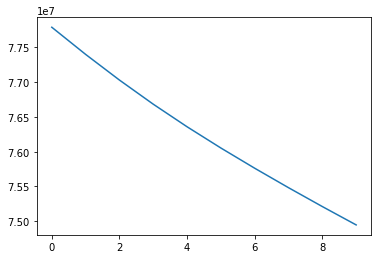

In [80]:
loss_xp_ls = tc.zeros(n_minibatch)
loss_theta_ls = tc.zeros(len(theta_ls))
loss_epoch = tc.zeros(n_epoch)
mse_epoch = tc.zeros(n_epoch)



for epoch in tqdm(range(n_epoch)):
    for this_theta_idx in range(len(theta_ls)):
#         print("this_theta_idx = %d" %(this_theta_idx))
        for m in range(n_minibatch):        
            X = np.load(os.path.join(recon_path, 'sample3_recon.npy')).astype(np.float32)
            X = tc.from_numpy(X).to(dev)
#             print(X)
            y_hat = model[m](X, this_theta_idx)
            
#             print("y_hat = ")
#             print(y_hat)
            
#             print("y_true[this_theta_idx] = ")
#             print(y_true[this_theta_idx])
            
            loss = loss_fn(y_hat, y_true[this_theta_idx])
            loss_xp_ls[m] = loss
            optimizer[m].zero_grad()
            loss.backward()
            optimizer[m].step()
            
            
            X[:, :, minibatch_size*m:minibatch_size*(m+1),:] = model[m].xp
            X[:, :, minibatch_size*m:minibatch_size*(m+1),:] = X[:, :, minibatch_size*m:minibatch_size*(m+1),:].clamp(0,10)
            X = tc.tensor(X.detach().cpu().numpy())
            np.save(os.path.join(recon_path, 'sample3_recon.npy'), X)

        loss_theta_ls[this_theta_idx] = tc.sum(loss_xp_ls)
    loss_epoch[epoch] = tc.mean(loss_theta_ls)
    mse_epoch[epoch] = tc.mean(tc.square(X - X_true))
#     print(loss_epoch[epoch])
    tqdm._instances.clear()   

plt.plot(loss_epoch.detach().numpy())
plt.savefig(os.path.join(recon_path, 'loss_photon_count_epoch.pdf'))

np.save(os.path.join(recon_path, 'loss_photon_count_epoch.npy'), loss_epoch.detach().numpy())  
np.save(os.path.join(recon_path, 'mse_model.npy'), mse_epoch) 

with open(os.path.join(recon_path, 'recon_parameters.txt'), "w") as recon_paras:
    recon_paras.writelines("%s\n" %element for element in element_ls)
    recon_paras.write("n_minibatch = %d" %n_minibatch)
    recon_paras.write("theta_st = %.2f\n" %theta_st)
    recon_paras.write("theta_end = %.2f\n" %theta_end)
    recon_paras.write("n_theta = %d\n" %n_theta)
    recon_paras.write("sample_size_n = %d\n" %sample_size_n)
    recon_paras.write("sample_height_n = %d\n" %sample_height_n)
    recon_paras.write("sample_size_cm = %.2f\n" %sample_size_cm)
    recon_paras.write("probe_energy = %.2f\n" %probe_energy[0])
    recon_paras.write("probe_cts = %.2e\n" %probe_cts)
    recon_paras.write("n_det = %d\n" %n_det)
    recon_paras.write("det_size_cm = %.2f\n" %det_size_cm)
    recon_paras.write("det_from_sample_cm = %.2f\n" %det_from_sample_cm)

         
    
# Check whether model.parameters() is model.x
#     print('Is model.parameters()= model.x?', list(model.parameters())[0] is model.x, '\n') # or print(list(model.parameters())[0] == model.x)
#     print('Print model.x', model.x, '\n')
#     print('Loss for angle {}: {}'.format(i, loss.item()) )

torch.Size([5, 1, 5, 5])


Text(0.5, 1.0, 'intensity')

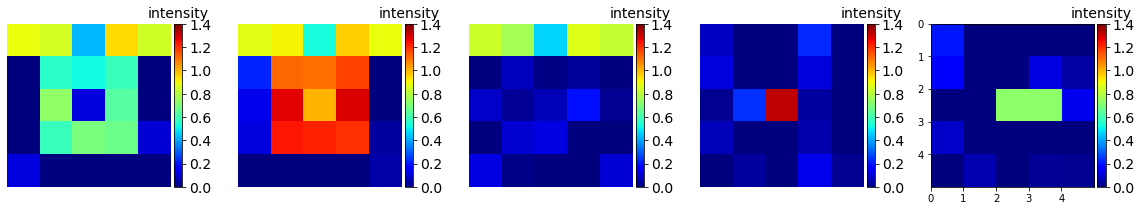

In [81]:
X = np.load(os.path.join(recon_path, 'sample3_recon.npy'))
X = tc.tensor(X)
print(X.shape)
os.path.join(recon_path, 'sample3_recon.npy')

image_size = 5
fig6 = plt.figure(figsize=(20,3))
gs6 = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[1,1,1,1,1])

fig6_ax1 = fig6.add_subplot(gs6[0,0])
fig6_ax1.set_xticks(np.arange(0, image_size, 1))
fig6_ax1.set_yticks(np.arange(0, image_size, 1))
# fig6_ax1.grid(color='w', linewidth=2)
fig6_ax1.axis('off')
pos = fig6_ax1.imshow(X[0,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax2 = fig6.add_subplot(gs6[0,1])
fig6_ax2.set_xticks(np.arange(0, image_size, 1))
fig6_ax2.set_yticks(np.arange(0, image_size, 1))
# fig6_ax2.grid(color='w', linewidth=2)
fig6_ax2.axis('off')
pos = fig6_ax2.imshow(X[1,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax3 = fig6.add_subplot(gs6[0,2])
fig6_ax3.set_xticks(np.arange(0, image_size, 1))
fig6_ax3.set_yticks(np.arange(0, image_size, 1))
# fig6_ax3.grid(color='w', linewidth=2)
fig6_ax3.axis('off')
pos = fig6_ax3.imshow(X[2,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax4 = fig6.add_subplot(gs6[0,3])
fig6_ax4.set_xticks(np.arange(0, image_size, 1))
fig6_ax4.set_yticks(np.arange(0, image_size, 1))
# fig6_ax4.grid(color='w', linewidth=2)
fig6_ax4.axis('off')
pos = fig6_ax4.imshow(X[3,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax5 = fig6.add_subplot(gs6[0,4])
fig6_ax5.set_xticks(np.arange(0, image_size, 1))
fig6_ax5.set_yticks(np.arange(0, image_size, 1))
# fig6_ax5.grid(color='w', linewidth=2)
# fig6_ax5.axis('off')
pos = fig6_ax5.imshow(X[4,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

Text(0.5, 1.0, 'intensity')

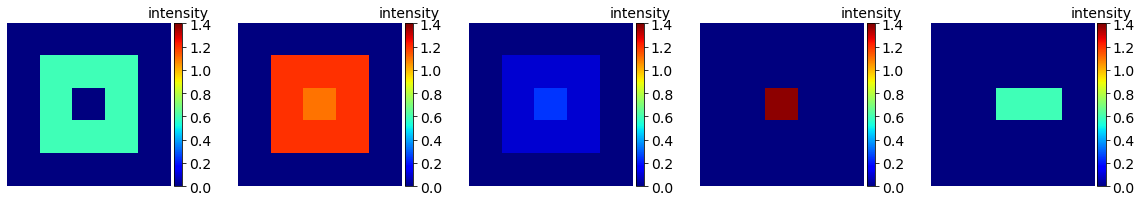

In [79]:
## Plot true models

X_true = np.load('./data/sample3_pad/grid_concentration.npy')

fig6 = plt.figure(figsize=(20,3))
gs6 = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[1,1,1,1,1])

fig6_ax1 = fig6.add_subplot(gs6[0,0])
fig6_ax1.set_xticks(np.arange(0, image_size, 1))
fig6_ax1.set_yticks(np.arange(0, image_size, 1))
# fig6_ax1.grid(color='w', linewidth=2)
fig6_ax1.axis('off')
pos = fig6_ax1.imshow(X_true[0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 20, 20, 0], origin='upper')
divider = make_axes_locatable(fig6_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax2 = fig6.add_subplot(gs6[0,1])
fig6_ax2.set_xticks(np.arange(0, image_size, 1))
fig6_ax2.set_yticks(np.arange(0, image_size, 1))
# fig6_ax2.grid(color='w', linewidth=2)
fig6_ax2.axis('off')
pos = fig6_ax2.imshow(X_true[1], cmap='jet', vmin=0, vmax=1.4, extent=[0, 20, 20, 0], origin='upper')
divider = make_axes_locatable(fig6_ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax3 = fig6.add_subplot(gs6[0,2])
fig6_ax3.set_xticks(np.arange(0, image_size, 1))
fig6_ax3.set_yticks(np.arange(0, image_size, 1))
# fig6_ax3.grid(color='w', linewidth=2)
fig6_ax3.axis('off')
pos = fig6_ax3.imshow(X_true[2], cmap='jet', vmin=0, vmax=1.4, extent=[0, 20, 20, 0], origin='upper')
divider = make_axes_locatable(fig6_ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax4 = fig6.add_subplot(gs6[0,3])
fig6_ax4.set_xticks(np.arange(0, image_size, 1))
fig6_ax4.set_yticks(np.arange(0, image_size, 1))
# fig6_ax4.grid(color='w', linewidth=2)
fig6_ax4.axis('off')
pos = fig6_ax4.imshow(X_true[3], cmap='jet', vmin=0, vmax=1.4, extent=[0, 20, 20, 0], origin='upper')
divider = make_axes_locatable(fig6_ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax5 = fig6.add_subplot(gs6[0,4])
fig6_ax5.set_xticks(np.arange(0, image_size, 1))
fig6_ax5.set_yticks(np.arange(0, image_size, 1))
# fig6_ax5.grid(color='w', linewidth=2)
fig6_ax5.axis('off')
pos = fig6_ax5.imshow(X_true[4], cmap='jet', vmin=0, vmax=1.4, extent=[0, 20, 20, 0], origin='upper')
divider = make_axes_locatable(fig6_ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

## Constant initial guess (0.5)

In [26]:
class PPM(nn.Module):
    
    fl_line_groups=np.array(["K", "L", "M"]) 
    fl_K=fl_K
    fl_L=fl_L
    fl_M=fl_M
    group_lines=True
    
    def __init__(self, grid_concentration, p, n_element, sample_height_n, minibatch_size, sample_size_n, 
                 this_aN_dic, probe_energy, probe_cts, sample_size_cm, fl_line_groups, fl_K, fl_L, fl_M, group_lines, 
                 theta_st, theta_end, n_theta, 
                 n_det, det_size_cm, det_from_sample_cm):
        """
        Initialize the attributes of PPM. 
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        self.grid_concentration = grid_concentration
        self.n_element = n_element
        self.sample_height_n = sample_height_n
        self.minibatch_size = minibatch_size
        self.sample_size_n = sample_size_n
        self.p = p  # indicate which minibatch to calculate the gradient  
        self.xp = self.init_xp() # initialize the values of the minibatch
        
        self.probe_energy = probe_energy  
        self.this_aN_dic = this_aN_dic
        self.n_element = tc.tensor(len(self.this_aN_dic)).to(dev)
        self.element_ls = np.array(list(this_aN_dic.keys()))
        self.aN_ls = np.array(list(this_aN_dic.values()))
        
        self.probe_attCS_ls = tc.tensor(xlib_np.CS_Total(self.aN_ls, self.probe_energy).flatten()).to(dev)
#         self.probe_attCS_dic = dict(zip(self.element_ls, self.probe_attCS_ls))
        
        self.sample_size_cm = sample_size_cm
        self.fl_line_groups = fl_line_groups
        self.fl_K = fl_K
        self.fl_L = fl_L
        self.fl_M = fl_M
        self.group_lines = group_lines
        self.fl_all_lines_dic = self.init_fl_all_lines_dic()
        self.n_lines = tc.tensor(self.fl_all_lines_dic["n_lines"]).to(dev)
        self.FL_line_attCS_ls = tc.tensor(xlib_np.CS_Total(self.aN_ls, self.fl_all_lines_dic["fl_energy"])).to(dev)
        self.detected_fl_unit_concentration = tc.tensor(self.fl_all_lines_dic["detected_fl_unit_concentration"]).to(dev)
        self.n_line_group_each_element = tc.IntTensor(self.fl_all_lines_dic["n_line_group_each_element"]).to(dev)
        
        self.theta_ls = - tc.linspace(theta_st, theta_end, n_theta)
        
        self.n_det = n_det
        self.det_size_cm = det_size_cm
        self.det_from_sample_cm = det_from_sample_cm
        self.P = tc.tensor(self.init_intersecting_length_fl_detectorlet()).to(dev)
        
        self.probe_cts = probe_cts
        self.probe_before_attenuation_flat = self.init_probe()

        
    def init_xp(self):
        """
        Initialize self.x with the tensor of the true model(noise may already be added) (n_element, n_z, minibatch_size (n_x is minibatched), n_y)
        """
        return nn.Parameter(tc.zeros(self.n_element, self.sample_height_n, self.minibatch_size, self.sample_size_n) + 0.5)
#         return nn.Parameter(self.grid_concentration[:, :, self.minibatch_size * self.p:self.minibatch_size*(self.p+1),:])

    def init_fl_all_lines_dic(self):
        """
        Initialize self.fl_all_lines_dic
        """
        fl_all_lines_dic = MakeFLlinesDictionary(self.this_aN_dic, self.probe_energy,
                      self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy(),
                      self.fl_line_groups, self.fl_K, self.fl_L, self.fl_M,
                      self.group_lines)
        return fl_all_lines_dic
    
    def init_intersecting_length_fl_detectorlet(self):
        """
        Initialize self.intersecting_length_fl_detectorlet
        """
        
        P = intersecting_length_fl_detectorlet(self.n_det.cpu().numpy(), self.det_size_cm, self.det_from_sample_cm, self.sample_size_n.cpu().numpy(), self.sample_size_cm.cpu().numpy())
        return P
    
    def init_probe(self):
        return self.probe_cts * tc.ones((self.sample_height_n * self.sample_size_n * self.sample_size_n), device=dev)
    
    def forward(self, grid_concentration, this_theta_idx):  # convert X to y_hat; dimension changes from (5, 30, 30) to (30, 8)
        start_time = time.time()
        """
        Forward propagation.
        """      
        
        ### 1: Calculate the map of attenuation and transmission ###
        grid_concentration[:, :, minibatch_size * self.p:minibatch_size * (self.p+1), :] = self.xp
        theta = self.theta_ls[this_theta_idx]

        att_exponent_acc_map = tc.zeros((self.sample_height_n, self.sample_size_n, self.sample_size_n+1), device=dev)
        concentration_map_rot = rotate(grid_concentration, theta)
        for j in range(self.n_element):
            lac_single = concentration_map_rot[j] * self.probe_attCS_ls[j]
            lac_acc = tc.cumsum(lac_single, axis=2)            
            lac_acc = tc.cat((tc.zeros((self.sample_height_n, self.sample_size_n, 1), device=dev), lac_acc), dim = 2)
            att_exponent_acc = lac_acc * (self.sample_size_cm / self.sample_size_n)    
            att_exponent_acc_map += att_exponent_acc
        attenuation_map_theta_flat = tc.exp(-(att_exponent_acc_map[:,:,:-1])).view(self.sample_height_n * self.sample_size_n * self.sample_size_n)
        transmission_theta = tc.exp(-att_exponent_acc_map[:,:,-1]).view(self.sample_height_n * self.sample_size_n)

        fl_map_tot_flat_theta = tc.zeros((self.n_lines, self.sample_height_n * self.sample_size_n * self.sample_size_n), device=dev)
        concentration_map_rot_flat = concentration_map_rot.view(self.n_element, self.sample_height_n * self.sample_size_n * self.sample_size_n)
        
        line_idx = 0
        for j in range(self.n_element):
            fl_unit = self.detected_fl_unit_concentration[line_idx:line_idx + self.n_line_group_each_element[j]]
            
            ## FL signal over the current elemental lines for each voxel
            fl_map = [concentration_map_rot_flat[j] * fl_unit_single_line for fl_unit_single_line in fl_unit]
            fl_map = tc.stack(fl_map)   

            fl_map_tot_flat_theta[line_idx:line_idx + fl_map.shape[0],:] = fl_map            
            line_idx = line_idx + len(fl_unit)
            
        ### 3: Calculate SA (the map of attenuation ratio due to self-absorption of the FL signal):
        # 1. for each FL emitting source voxel (sample_size x sample_size),
        # 2. we have an attenuation ratio when the photon for each elemental line reaches the edge of the sample (due to self absorption) (n_elemental_line)


        #### The dimension of SA:
        # (n_theta, sample_size * sample_size, n_elemental_line)
        # generate an arrary of total attenuation cross section with the dimension: (n_element, n_elemental_lines)
        # The component in the array represents the total attenuation cross section at some line energy in some element (with unitary concentration)

        # P = intersecting_length_fl_detectorlet(self.n_det, self.det_size_cm, self.det_from_sample_cm, self.sample_size_n, self.sample_size_cm)
        SA_theta = tc.zeros((self.n_lines, self.sample_height_n * self.sample_size_n * self.sample_size_n), device=dev)
        for j in range(self.sample_height_n * self.sample_size_n * self.sample_size_n):       
            att_exponent_elemental_sum_temp = tc.zeros((self.n_element, self.n_det, self.n_lines), device=dev)
            for k in range(self.n_element):

                ## llinear attenuation coefficient for each fl-line at each voxel: (self.n_lines, sample_size * sample_size)
                lac = tc.stack([FL_line_attCS * concentration_map_rot_flat[k] for FL_line_attCS in self.FL_line_attCS_ls[k]], dim=1)

                ## att_exponent = [(intersecting_length_path1 * lac), (intersecting_length_path2 * lac), ..., (intersecting_length_path5 * lac)]:
                ## att_exponent (for each fl-line, at each_voxel, for each beam path): (self.n_det, sample_size * sample_size, self.n_lines)
                att_exponent = tc.stack([tc.unsqueeze(self.P[m,j,:], dim=1) * lac for m in range(self.n_det)])


                ## att_exponent summing over voxels (for each line, for each beam path): (self.n_det, n_elemental_line)
                att_exponent_voxel_sum = tc.sum(att_exponent, axis=1)

                ## filling att_exponent_voxel_sum to att_exponent_elemental_sum for each element
                att_exponent_elemental_sum_temp[k, :, :] = att_exponent_voxel_sum

            ## summing over the attenation exponent contributed by each element
            att_exponent_elemental_sum =  tc.sum(att_exponent_elemental_sum_temp, axis=0)  

            ## calculate the attenuation caused by all elements
            att = tc.exp(- att_exponent_elemental_sum)

            ## calculate the attenuation averaged all paths
            att_path_ave = tc.mean(att, axis=0)
            SA_theta[:,j] = att_path_ave
              
        #### Create XRF data ####
        probe_after_attenuation_theta = self.probe_before_attenuation_flat * attenuation_map_theta_flat  

        fl_signal_wo_SA_theta = tc.unsqueeze(probe_after_attenuation_theta, dim=0) * fl_map_tot_flat_theta
        fl_signal_SA_theta = fl_signal_wo_SA_theta * SA_theta


        fl_signal_SA_theta = fl_signal_SA_theta.view(-1, self.sample_height_n * self.sample_size_n, self.sample_size_n)
        fl_signal_SA_theta = tc.sum(fl_signal_SA_theta, axis=2)
        output = fl_signal_SA_theta
#         print("running_time = %.3f" %(time.time() - start_time))
        return output

In [27]:
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(np.pi).to(dev)
n_theta =  tc.tensor(5).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta).to(dev)
# this_theta_idx = tc.tensor(0).to(dev)
sample_size_n = tc.tensor(5).to(dev)
sample_height_n = tc.tensor(1).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"C": 6, "O": 8, "Si": 14, "Ca": 20, "Fe": 26}
probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
n_det = tc.tensor(5).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6

fl_line_groups = np.array(["K", "L", "M"])
fl_K = fl_K
fl_L = fl_L
fl_M = fl_M
group_lines = True


element_ls = np.array(list(this_aN_dic.keys()))

In [41]:
X = np.load(os.path.join('./data/sample3_pad', 'grid_concentration.npy')).astype(np.float32)  # The shape of X(2d) is initally (5,5,5) = (n_element, n_x, n_y)
X = X[:,np.newaxis,:,:]  # Create a new dimension for n_z; n_z = 1 for a 2d object
# X = X + 0.1 * np.random.randn(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
# X = np.clip(X, 0, 10)
print(X.shape)
# print(X)

X = tc.zeros(len(this_aN_dic), sample_height_n, sample_size_n, sample_size_n) + 0.5

# save the initial guess to the folder that saves the results of reconstruction
recon_path = 'data/sample3_recon'  
np.save(os.path.join(recon_path, 'sample3_recon.npy'), X)

(5, 1, 5, 5)


In [42]:
# y_true = tc.randn(n_theta, 8, 10)
y_true = data.to(dev)
# print(y_true.shape)
# print(y_true)

X = np.array(X).astype(np.float32)
X = tc.from_numpy(X).float().to(dev) 

n_element = tc.tensor(len(this_aN_dic)).to(dev)

n_minibatch = tc.tensor(1).to(dev)

minibatch_size = tc.tensor(X.shape[1]//n_minibatch).to(dev)

model = [PPM(X, m, n_element, sample_height_n, minibatch_size, sample_size_n, this_aN_dic, probe_energy, probe_cts,
             sample_size_cm, fl_line_groups, fl_K, fl_L, fl_M, group_lines, theta_st, theta_end, n_theta,
             n_det, det_size_cm, det_from_sample_cm).to(dev) for m in range(n_minibatch)]

loss_fn = nn.MSELoss()
optimizer = [tc.optim.Adam(model[m].parameters(), lr=0.01) for m in range(n_minibatch)]
X_true = tc.from_numpy(np.load(os.path.join('./data/sample3_pad', 'grid_concentration.npy')).astype(np.float32))

/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]], device='cuda:1')


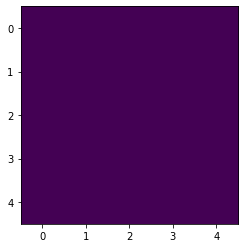

In [30]:
print(X[0,0])
plt.imshow(X[0,0].cpu())

In [31]:
n_epoch = 10

  0%|          | 0/10 [00:00<?, ?it/s]/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


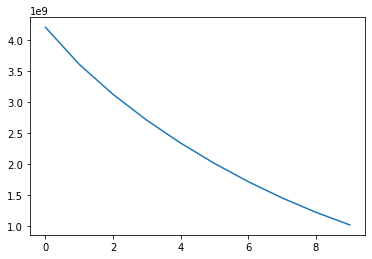

In [119]:
loss_xp_ls = tc.zeros(n_minibatch)
loss_theta_ls = tc.zeros(len(theta_ls))
loss_epoch = tc.zeros(n_epoch)
mse_epoch = tc.zeros(n_epoch)

for epoch in tqdm(range(n_epoch)):
    for this_theta_idx in range(len(theta_ls)):
#         print("this_theta_idx = %d" %(this_theta_idx))
        for m in range(n_minibatch):        
            X = np.load(os.path.join(recon_path, 'sample3_recon.npy')).astype(np.float32)
            X = tc.from_numpy(X).to(dev)
#             print(X)
            y_hat = model[m](X, this_theta_idx)
            
#             print("y_hat = ")
#             print(y_hat)
            
#             print("y_true[this_theta_idx] = ")
#             print(y_true[this_theta_idx])
            
            loss = loss_fn(y_hat, y_true[this_theta_idx])
            loss_xp_ls[m] = loss
            optimizer[m].zero_grad()
            loss.backward()
            optimizer[m].step()
            
            
            X[:, :, minibatch_size*m:minibatch_size*(m+1),:] = model[m].xp
            X[:, :, minibatch_size*m:minibatch_size*(m+1),:] = X[:, :, minibatch_size*m:minibatch_size*(m+1),:].clamp(0,10)
            X = tc.tensor(X.detach().cpu().numpy())
            np.save(os.path.join(recon_path, 'sample3_recon.npy'), X)
#         print("updated model after a theta")
#         print(X)    
        loss_theta_ls[this_theta_idx] = tc.sum(loss_xp_ls)
    loss_epoch[epoch] = tc.mean(loss_theta_ls)
    mse_epoch[epoch] = tc.mean(tc.square(X - X_true))
#     print(loss_epoch[epoch])
    tqdm._instances.clear()   

plt.plot(loss_epoch.detach().numpy())
plt.savefig(os.path.join(recon_path, 'loss_photon_count_epoch.pdf'))

np.save(os.path.join(recon_path, 'loss_photon_count_epoch.npy'), loss_epoch.detach().numpy())  
np.save(os.path.join(recon_path, 'mse_model.npy'), mse_epoch) 

with open(os.path.join(recon_path, 'recon_parameters.txt'), "w") as recon_paras:
    recon_paras.writelines("%s\n" %element for element in element_ls)
    recon_paras.write("n_minibatch = %d" %n_minibatch)
    recon_paras.write("theta_st = %.2f\n" %theta_st)
    recon_paras.write("theta_end = %.2f\n" %theta_end)
    recon_paras.write("n_theta = %d\n" %n_theta)
    recon_paras.write("sample_size_n = %d\n" %sample_size_n)
    recon_paras.write("sample_height_n = %d\n" %sample_height_n)
    recon_paras.write("sample_size_cm = %.2f\n" %sample_size_cm)
    recon_paras.write("probe_energy = %.2f\n" %probe_energy[0])
    recon_paras.write("probe_cts = %.2e\n" %probe_cts)
    recon_paras.write("n_det = %d\n" %n_det)
    recon_paras.write("det_size_cm = %.2f\n" %det_size_cm)
    recon_paras.write("det_from_sample_cm = %.2f\n" %det_from_sample_cm)


# Check whether model.parameters() is model.x
#     print('Is model.parameters()= model.x?', list(model.parameters())[0] is model.x, '\n') # or print(list(model.parameters())[0] == model.x)
#     print('Print model.x', model.x, '\n')
#     print('Loss for angle {}: {}'.format(i, loss.item()) )

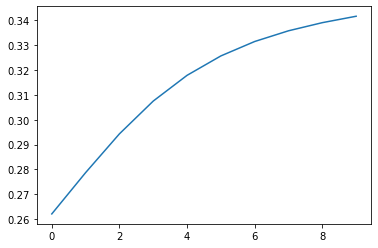

In [120]:
plt.plot(mse_epoch)
plt.savefig(os.path.join(recon_path, 'mse_epoch.pdf'))

torch.Size([5, 1, 5, 5])


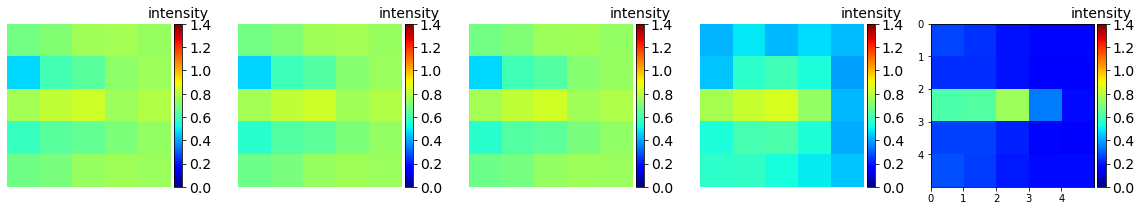

In [121]:
X = np.load(os.path.join(recon_path, 'sample3_recon.npy'))
X = tc.tensor(X)
print(X.shape)

image_size = 5
fig6 = plt.figure(figsize=(20,3))
gs6 = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[1,1,1,1,1])

fig6_ax1 = fig6.add_subplot(gs6[0,0])
fig6_ax1.set_xticks(np.arange(0, image_size, 1))
fig6_ax1.set_yticks(np.arange(0, image_size, 1))
# fig6_ax1.grid(color='w', linewidth=2)
fig6_ax1.axis('off')
pos = fig6_ax1.imshow(X[0,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax2 = fig6.add_subplot(gs6[0,1])
fig6_ax2.set_xticks(np.arange(0, image_size, 1))
fig6_ax2.set_yticks(np.arange(0, image_size, 1))
# fig6_ax2.grid(color='w', linewidth=2)
fig6_ax2.axis('off')
pos = fig6_ax2.imshow(X[1,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax3 = fig6.add_subplot(gs6[0,2])
fig6_ax3.set_xticks(np.arange(0, image_size, 1))
fig6_ax3.set_yticks(np.arange(0, image_size, 1))
# fig6_ax3.grid(color='w', linewidth=2)
fig6_ax3.axis('off')
pos = fig6_ax3.imshow(X[2,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax4 = fig6.add_subplot(gs6[0,3])
fig6_ax4.set_xticks(np.arange(0, image_size, 1))
fig6_ax4.set_yticks(np.arange(0, image_size, 1))
# fig6_ax4.grid(color='w', linewidth=2)
fig6_ax4.axis('off')
pos = fig6_ax4.imshow(X[3,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

fig6_ax5 = fig6.add_subplot(gs6[0,4])
fig6_ax5.set_xticks(np.arange(0, image_size, 1))
fig6_ax5.set_yticks(np.arange(0, image_size, 1))
# fig6_ax5.grid(color='w', linewidth=2)
# fig6_ax5.axis('off')
pos = fig6_ax5.imshow(X[4,0], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig6_ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

dxchange.write_tiff(X, os.path.join(recon_path, "recon_grid"), dtype='float32', overwrite=True)

uint8


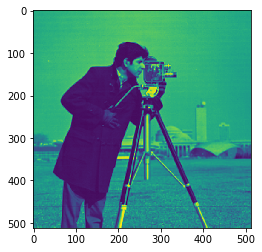

In [67]:
from skimage import data
from skimage.transform import rescale
image = data.camera()
print(image.dtype)
plt.imshow(image)

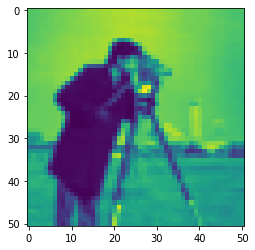

In [73]:
image_scale = rescale(image, 0.1)
plt.imshow(image_scale)

In [74]:
rescale(image, 0.5).shape

(256, 256)

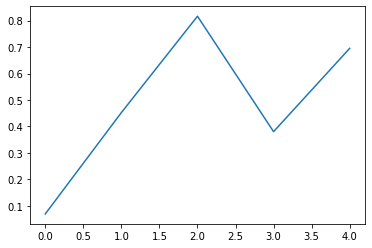

In [264]:
a = tc.rand(5)
plt.plot(a)